In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.0.1.post2
Populating the interactive namespace from numpy and matplotlib


In [0]:
!mkdir results

# Pandas Datareader Test

In [0]:

 
# We will look at stock prices over the past year, starting at January 1, 2016
start = (2000, 12, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

google = pdr.DataReader('028050.KS', 'yahoo', start, end)

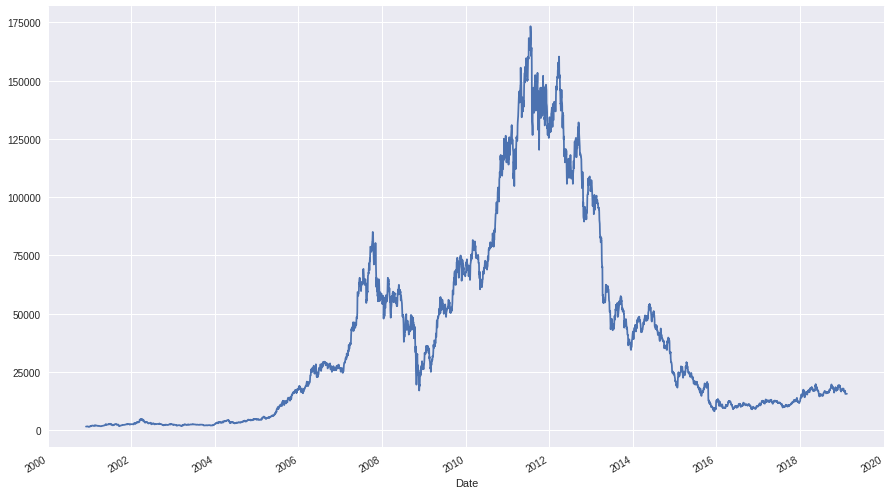

In [4]:
google.Low.plot(grid=True)

In [5]:
google.tail()
print(google.isna().sum())

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


# Data Preparation

In [0]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = pdr.DataReader(self.symbol, 'yahoo', self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']]
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

# Model Define

In [0]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [0]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

# Train, Validate, Test 

In [0]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [0]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [0]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [0]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment

In [0]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [0]:

def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [15]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 128
args.x_frames = 5
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.0
args.dropout = 0.0
args.use_bn = False

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 5



trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

# ====== Experiment Variable ====== #
def grid_hyperparameter_tuning(namespace, expname, name_var1, list_var1, name_var2, list_var2):
    namespace.exp_name = expname
    for var1 in list_var1:
        for var2 in list_var2:
            setattr(namespace, name_var1, var1)
            setattr(namespace, name_var2, var2)
            print(namespace)

            setting, result = experiment(partition, deepcopy(namespace))
            save_exp_result(setting, result)

def random_hyperparameter_tuning(namespace, expname, num, name_var1, list_var1, name_var2, list_var2):
    namespace.exp_name = expname
    for i in range(num):
        setattr(namespace, name_var1, int(np.random.choice(list_var1)))
        setattr(namespace, name_var2, int(np.random.choice(list_var2)))
        
        setting, result = experiment(partition, deepcopy(namespace))
        save_exp_result(setting, result)


High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


In [0]:
def loss_analysis(df):

    val_loss_frame = df['val_losses']
    train_loss_frame = df['train_losses']

    min_val_losses = []
    last_val_losses = []
    min_val_losses_diff = []
    last_losses_diff = []
    for i in range(len(val_loss_frame)):
        val_losses = val_loss_frame[i]
        train_losses = train_loss_frame[i]

        ind_val_loss_min = val_losses.index(min(val_losses))
        min_val_losses.append(val_losses[ind_val_loss_min])
        last_val_losses.append(val_losses[len(val_losses) - 1])

        min_val_losses_diff.append(val_losses[ind_val_loss_min] - train_losses[ind_val_loss_min])
        last_losses_diff.append(val_losses[len(val_losses) - 1] - train_losses[len(val_losses) - 1])
    
    return min_val_losses, last_val_losses, min_val_losses_diff, last_losses_diff

In [0]:
def minimizer(df, var1, var2, mode='min'):
    min_val_losses, last_val_losses, min_val_losses_diff, last_losses_diff = loss_analysis(df)
    var1_frame = df[var1]
    var2_frame = df[var2]
    if mode == 'min':
        ind = min_val_losses.index(min(min_val_losses))
        return var1_frame[ind], var2_frame[ind], min_val_losses[ind]
    else:
        ind = last_val_losses.index(min(last_val_losses))
        return var1_frame[ind], var2_frame[ind], last_val_losses[ind]
        
def regularizer(df, var1, var2, mode='min'):
    min_val_losses, last_val_losses, min_val_losses_diff, last_losses_diff = loss_analysis(df)
    var1_frame = df[var1]
    var2_frame = df[var2]
    if mode == 'min':
        ind = min_val_losses_diff.index(min(min_val_losses_diff))
        return var1_frame[ind], var2_frame[ind], min_val_losses_diff[ind]
    else:
        ind = last_losses_diff.index(min(last_losses_diff))
        return var1_frame[ind], var2_frame[ind], last_losses_diff[ind]

Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=5, exp_name='exp1_hid_dim__n_layers', hid_dim=32, input_dim=6, l2=0.0, lr=0.0001, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=False, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 2.51/2.37, Loss(train/val) 0.01689/0.01599. Took 18.49 sec
Epoch 1, Acc(train/val): 2.61/2.42, Loss(train/val) 0.01401/0.01380. Took 18.38 sec
Epoch 2, Acc(train/val): 2.65/2.44, Loss(train/val) 0.01224/0.01203. Took 18.27 sec
Epoch 3, Acc(train/val): 2.67/2.43, Loss(train/val) 0.01062/0.01050. Took 18.09 sec
Epoch 4, Acc(train/val): 2.71/2.61, Loss(train/val) 0.00926/0.00902. Took 18.27 sec
Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=5, exp_name='exp1_hid_dim__n_layers', hid_dim=32, input_dim=6, l2=0.0, lr=0.0001, n_layers=2, optim='RMSprop', symbol='028050.KS', use_bn=False, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 3.56/2.47, Loss(train/val) 0.02271/0.01822. Took 18.31 sec
Epoch 1, Acc(train/val): 2.80/2.12, Lo

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


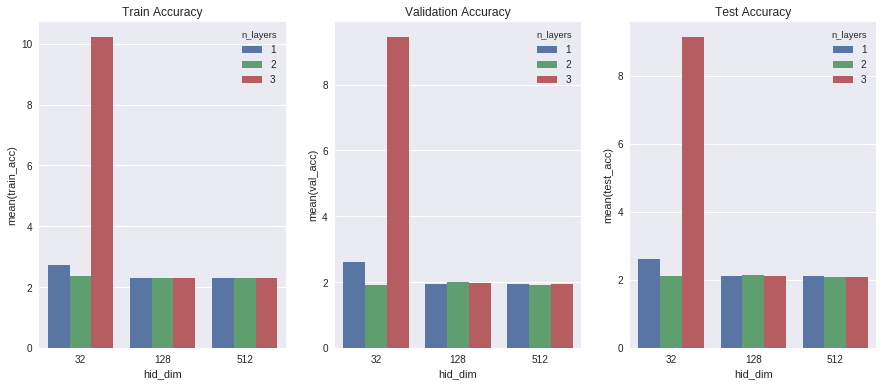

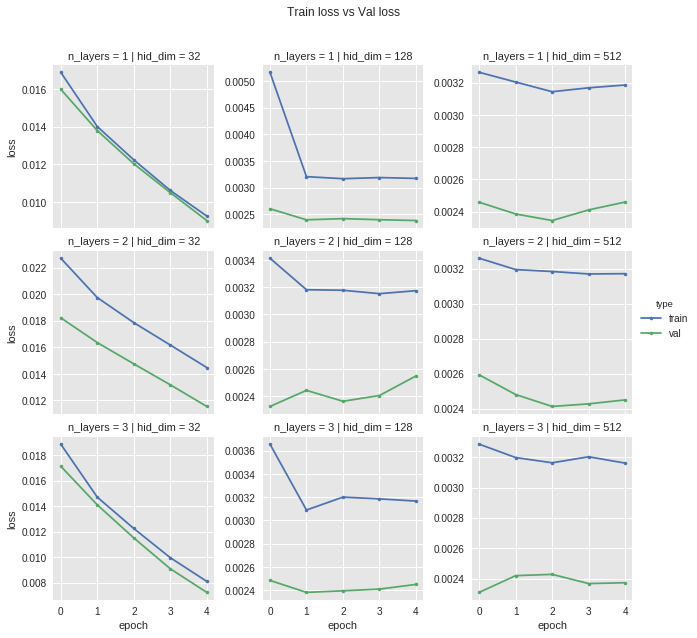

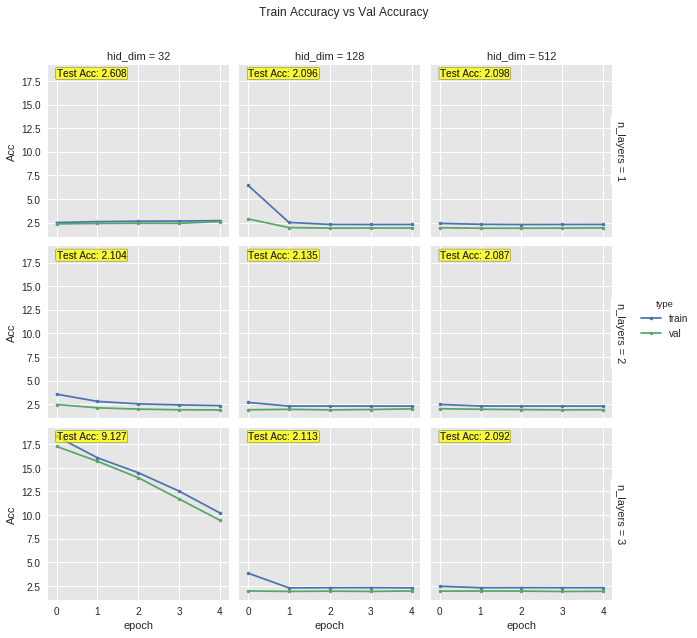

In [18]:
grid_hyperparameter_tuning(deepcopy(args), "exp1_hid_dim__n_layers", "hid_dim", [32, 128, 512], "n_layers", [1, 2, 3])

var1 = 'hid_dim'
var2 = 'n_layers'
df = load_exp_result('exp1_hid_dim__n_layers')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

var1_var2 = minimizer(df, var1, var2, mode = 'last')

In [19]:
random_hyperparameter_tuning(deepcopy(args), "exp1r_hid_dim__n_layers", 10, "hid_dim", [32, 64, 128, 256, 512], "n_layers", [1, 2, 3])

var1 = 'hid_dim'
var2 = 'n_layers'
df = load_exp_result('exp1r_hid_dim__n_layers')
display(df)

rvar1_var2 = minimizer(df, var1, var2, mode = 'last')

if var1_var2[2] < rvar1_var2[2]:
    setattr(args, var1, int(var1_var2[0]))
    setattr(args, var2, int(var1_var2[1]))
else:
    setattr(args, var1, int(rvar1_var2[0]))
    setattr(args, var2, int(rvar1_var2[1]))

Epoch 0, Acc(train/val): 2.38/1.91, Loss(train/val) 0.00324/0.00245. Took 19.27 sec
Epoch 1, Acc(train/val): 2.31/1.96, Loss(train/val) 0.00320/0.00242. Took 19.21 sec
Epoch 2, Acc(train/val): 2.32/1.90, Loss(train/val) 0.00320/0.00247. Took 19.06 sec
Epoch 3, Acc(train/val): 2.31/1.92, Loss(train/val) 0.00318/0.00236. Took 19.15 sec
Epoch 4, Acc(train/val): 2.29/1.97, Loss(train/val) 0.00314/0.00245. Took 19.33 sec
Epoch 0, Acc(train/val): 7.44/3.78, Loss(train/val) 0.01009/0.00549. Took 18.58 sec
Epoch 1, Acc(train/val): 2.89/1.90, Loss(train/val) 0.00461/0.00277. Took 18.60 sec
Epoch 2, Acc(train/val): 2.30/1.96, Loss(train/val) 0.00336/0.00241. Took 18.81 sec
Epoch 3, Acc(train/val): 2.30/1.94, Loss(train/val) 0.00317/0.00240. Took 18.48 sec
Epoch 4, Acc(train/val): 2.31/1.92, Loss(train/val) 0.00320/0.00241. Took 18.53 sec
Epoch 0, Acc(train/val): 2.46/1.91, Loss(train/val) 0.00322/0.00240. Took 18.79 sec
Epoch 1, Acc(train/val): 2.31/1.94, Loss(train/val) 0.00317/0.00247. Took 18

,batch_size,device,dropout,exp_name,hid_dim,input_dim,l2,lr,n_layers,optim,...,test_acc,train_acc,train_accs,train_losses,use_bn,val_acc,val_accs,val_losses,x_frames,y_frames
0,128,cuda,0.0,exp1r_hid_dim__n_layers,512,6,0.0,0.0001,2,RMSprop,...,2.087023,2.296740,"[2.456443325332973, 2.3064357508783755, 2.2939...","[0.0032154144111858764, 0.0031740933191031218,...",False,1.915869,"[1.9132225683757238, 1.9356065818241663, 1.933...","[0.0023984255801354137, 0.0024661298541884336,...",5,5
1,128,cuda,0.0,exp1r_hid_dim__n_layers,512,6,0.0,0.0001,3,RMSprop,...,2.082605,2.294541,"[2.3211577094119527, 2.315054318179255, 2.3156...","[0.003244667030546976, 0.00318046936603344, 0....",False,1.907108,"[2.0040697370256697, 1.9001609427588326, 1.934...","[0.002445954247377813, 0.0023382409209651606, ...",5,5
2,128,cuda,0.0,exp1r_hid_dim__n_layers,32,6,0.0,0.0001,2,RMSprop,...,2.101125,2.326585,"[6.592283331829568, 4.375664565874183, 3.10774...","[0.014112140375958837, 0.006965678974824107, 0...",False,1.901570,"[4.76331581388201, 3.108052526201521, 2.204500...","[0.00916059228724667, 0.005066671308928302, 0....",5,5
3,128,cuda,0.0,exp1r_hid_dim__n_layers,64,6,0.0,0.0001,1,RMSprop,...,2.089334,2.302756,"[2.421470175618711, 2.3377396023791768, 2.3144...","[0.009095462120097616, 0.006145957169001517, 0...",False,1.924978,"[1.9064580372401647, 1.9319358212607247, 1.925...","[0.005640350548284394, 0.003909925830417446, 0...",5,5
4,128,cuda,0.0,exp1r_hid_dim__n_layers,64,6,0.0,0.0001,3,RMSprop,...,2.085663,2.310251,"[7.4353409642758574, 2.888846262641575, 2.3023...","[0.010089616331717243, 0.0046104652726131935, ...",False,1.916117,"[3.7805412837437222, 1.9009613650185722, 1.956...","[0.0054934570964957985, 0.0027735294175467323,...",5,5
5,128,cuda,0.0,exp1r_hid_dim__n_layers,512,6,0.0,0.0001,1,RMSprop,...,2.110465,2.304482,"[2.542877814044123, 2.3208119402761045, 2.3082...","[0.0032936556305250397, 0.0031786691701120658,...",False,1.971569,"[1.9087082828794206, 1.9518082652773177, 1.922...","[0.002386334285672222, 0.002428695559501648, 0...",5,5
6,128,cuda,0.0,exp1r_hid_dim__n_layers,256,6,0.0,0.0001,3,RMSprop,...,2.081411,2.313636,"[2.6872970798741216, 2.307537213615749, 2.2995...","[0.0035427582915872335, 0.003185110956268466, ...",False,1.907237,"[1.9591142279761178, 1.938888498714992, 1.9600...","[0.0024529535356642945, 0.002409380827365177, ...",5,5
7,128,cuda,0.0,exp1r_hid_dim__n_layers,256,6,0.0,0.0001,1,RMSprop,...,2.100018,2.301120,"[2.428859689961309, 2.291967448980912, 2.30944...","[0.0033422028747103786, 0.0031446994727720385,...",False,1.952872,"[1.9345318589891707, 1.9156052214758736, 1.911...","[0.0023876516580847757, 0.0023908796720206738,...",5,5
8,128,cuda,0.0,exp1r_hid_dim__n_layers,128,6,0.0,0.0001,1,RMSprop,...,2.091076,2.306933,"[4.718561099923176, 2.330231542172639, 2.30225...","[0.0037641737448132558, 0.003180687730807973, ...",False,1.921159,"[2.0703143051692416, 1.9414347410202026, 1.918...","[0.0024149760470858644, 0.002426050736435822, ...",5,5


Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=5, exp_name='exp2_l2_dropout', hid_dim=512, input_dim=6, l2=10, lr=0.0001, n_layers=3, optim='RMSprop', symbol='028050.KS', use_bn=False, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 2.38/2.03, Loss(train/val) 0.00384/0.00274. Took 19.20 sec
Epoch 1, Acc(train/val): 2.34/1.98, Loss(train/val) 0.00363/0.00261. Took 19.12 sec
Epoch 2, Acc(train/val): 2.31/1.96, Loss(train/val) 0.00355/0.00253. Took 19.07 sec
Epoch 3, Acc(train/val): 2.31/1.95, Loss(train/val) 0.00348/0.00248. Took 19.13 sec
Epoch 4, Acc(train/val): 2.29/1.93, Loss(train/val) 0.00337/0.00243. Took 19.11 sec
Namespace(batch_size=128, device='cuda', dropout=0.1, epoch=5, exp_name='exp2_l2_dropout', hid_dim=512, input_dim=6, l2=10, lr=0.0001, n_layers=3, optim='RMSprop', symbol='028050.KS', use_bn=False, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 5.65/4.66, Loss(train/val) 0.00445/0.00336. Took 19.17 sec
Epoch 1, Acc(train/val): 4.88/4.12, Loss(train/val) 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Epoch 0, Acc(train/val): 2.34/1.90, Loss(train/val) 0.00328/0.00243. Took 18.90 sec
Epoch 1, Acc(train/val): 2.33/1.90, Loss(train/val) 0.00314/0.00242. Took 19.06 sec
Epoch 2, Acc(train/val): 2.32/1.90, Loss(train/val) 0.00319/0.00241. Took 19.06 sec
Epoch 3, Acc(train/val): 2.32/1.90, Loss(train/val) 0.00320/0.00240. Took 19.03 sec
Epoch 4, Acc(train/val): 2.31/2.03, Loss(train/val) 0.00319/0.00252. Took 19.08 sec
Epoch 0, Acc(train/val): 4.56/4.28, Loss(train/val) 0.00397/0.00283. Took 19.00 sec
Epoch 1, Acc(train/val): 3.98/3.85, Loss(train/val) 0.00379/0.00273. Took 19.09 sec
Epoch 2, Acc(train/val): 3.66/3.55, Loss(train/val) 0.00367/0.00266. Took 19.08 sec
Epoch 3, Acc(train/val): 3.43/3.31, Loss(train/val) 0.00359/0.00261. Took 19.07 sec
Epoch 4, Acc(train/val): 3.24/3.11, Loss(train/val) 0.00350/0.00257. Took 19.09 sec
Epoch 0, Acc(train/val): 2.40/2.01, Loss(train/val) 0.00323/0.00248. Took 19.01 sec
Epoch 1, Acc(train/val): 2.31/2.00, Loss(train/val) 0.00316/0.00244. Took 18

,batch_size,device,dropout,exp_name,hid_dim,input_dim,l2,lr,n_layers,optim,...,test_acc,train_acc,train_accs,train_losses,use_bn,val_acc,val_accs,val_losses,x_frames,y_frames
0,128,cuda,0,exp2r_l2_dropout,512,6,10,0.0001,3,RMSprop,...,2.085874,2.296127,"[2.3488990223926045, 2.294859642567842, 2.2960...","[0.004404869993500735, 0.004083333081444321, 0...",False,1.915668,"[1.9002607890537806, 1.9035985129220145, 1.906...","[0.0033932417697672334, 0.0031745508812101825,...",5,5
1,128,cuda,0,exp2r_l2_dropout,512,6,0,0.0001,3,RMSprop,...,2.087398,2.314229,"[2.4725651067236196, 2.2860611469849297, 2.290...","[0.0032812308763032374, 0.0031429975617515006,...",False,1.917772,"[1.9042171410151891, 1.9702757426670618, 1.991...","[0.0023576727669153896, 0.0024677439193640438,...",5,5


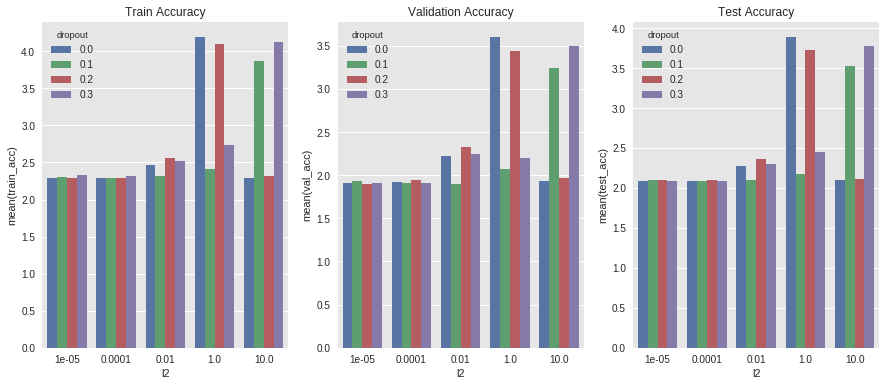

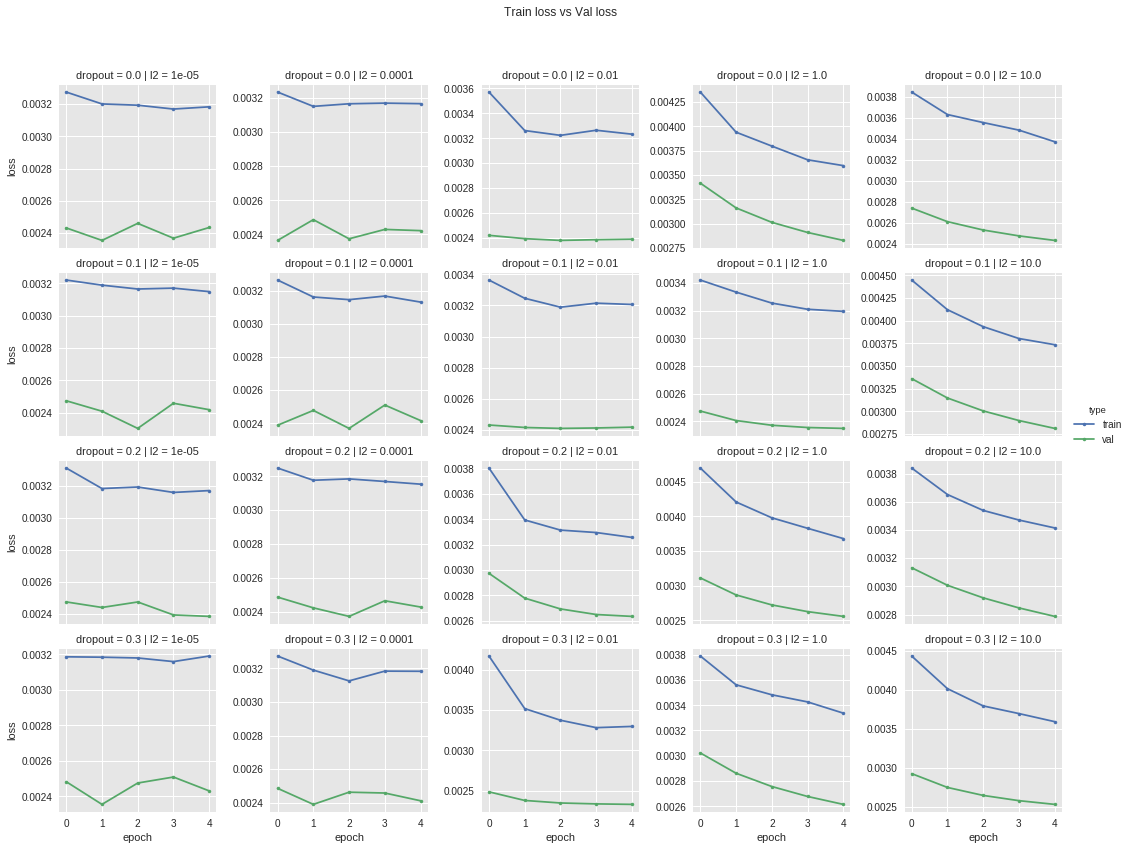

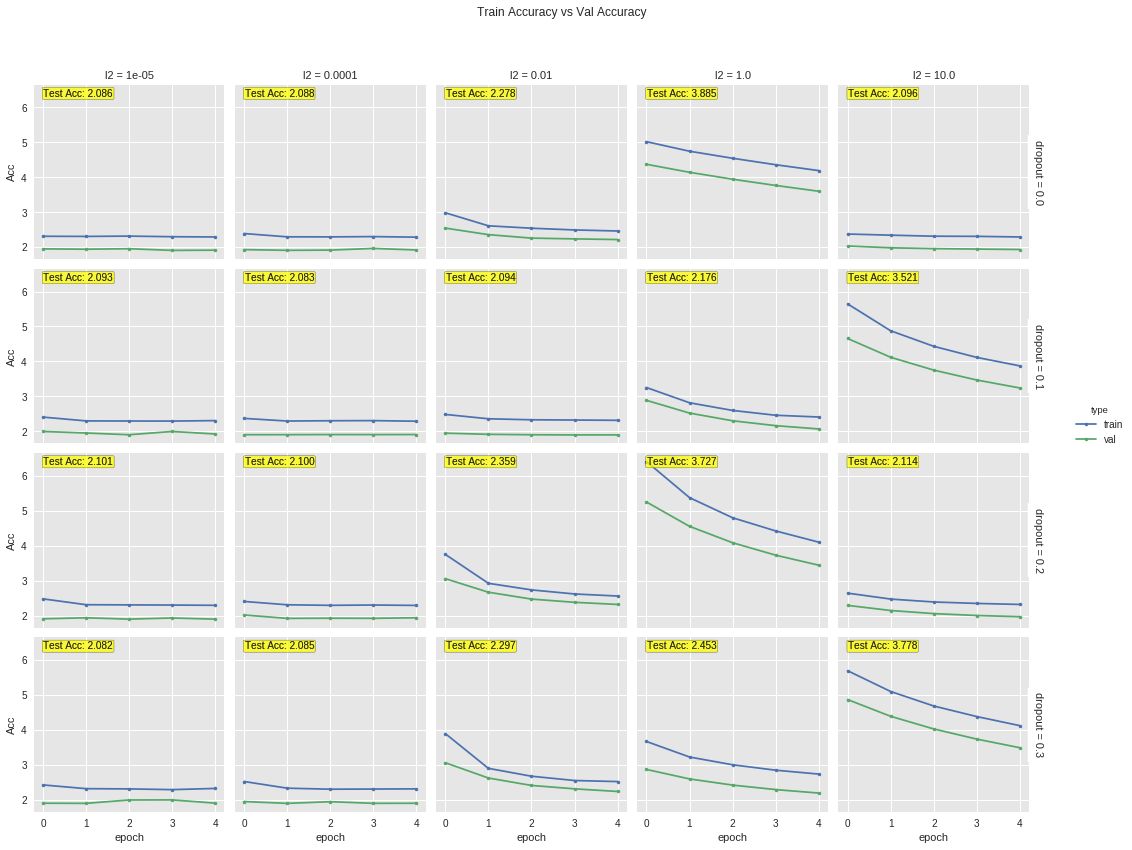

In [20]:
grid_hyperparameter_tuning(deepcopy(args), "exp2_l2_dropout", "l2", [10, 1, .01, .0001, .00001], "dropout", [.0, .1, .2, .3])

var1 = 'l2'
var2 = 'dropout'
df = load_exp_result('exp2_l2_dropout')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

var1_var2 = regularizer(df, var1, var2, mode = 'last')

random_hyperparameter_tuning(deepcopy(args), "exp2r_l2_dropout", 10, "l2", [10, 1, .1, .01, .001, .0001, .00001], "dropout", [.0, .05, .1, .15, .2, .25, .3])

var1 = 'l2'
var2 = 'dropout'
df = load_exp_result('exp2r_l2_dropout')

display(df)

rvar1_var2 = regularizer(df, var1, var2, mode = 'last')

if var1_var2[2] < rvar1_var2[2]:
    setattr(args, var1, float(var1_var2[0]))
    setattr(args, var2, float(var1_var2[1]))
else:
    setattr(args, var1, float(rvar1_var2[0]))
    setattr(args, var2, float(rvar1_var2[1]))

Namespace(batch_size=128, device='cuda', dropout=0.2, epoch=5, exp_name='exp3_l2_use_bn', hid_dim=512, input_dim=6, l2=0.1778279410038923, lr=0.0001, n_layers=3, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 3.19/2.07, Loss(train/val) 0.00516/0.00282. Took 19.36 sec
Epoch 1, Acc(train/val): 2.70/2.00, Loss(train/val) 0.00404/0.00270. Took 19.26 sec
Epoch 2, Acc(train/val): 2.54/1.96, Loss(train/val) 0.00376/0.00263. Took 19.30 sec
Epoch 3, Acc(train/val): 2.39/1.93, Loss(train/val) 0.00350/0.00259. Took 19.24 sec
Epoch 4, Acc(train/val): 2.35/1.92, Loss(train/val) 0.00339/0.00256. Took 19.18 sec
Namespace(batch_size=128, device='cuda', dropout=0.2, epoch=5, exp_name='exp3_l2_use_bn', hid_dim=512, input_dim=6, l2=0.1778279410038923, lr=0.0001, n_layers=3, optim='RMSprop', symbol='028050.KS', use_bn=False, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 3.82/3.09, Loss(train/val) 0.00357/0.00257. Took 19.13 sec
Epoch 1, Acc(train/val)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


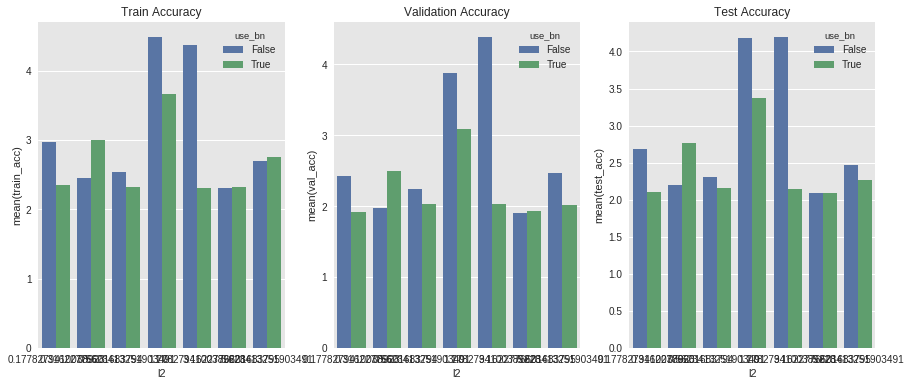

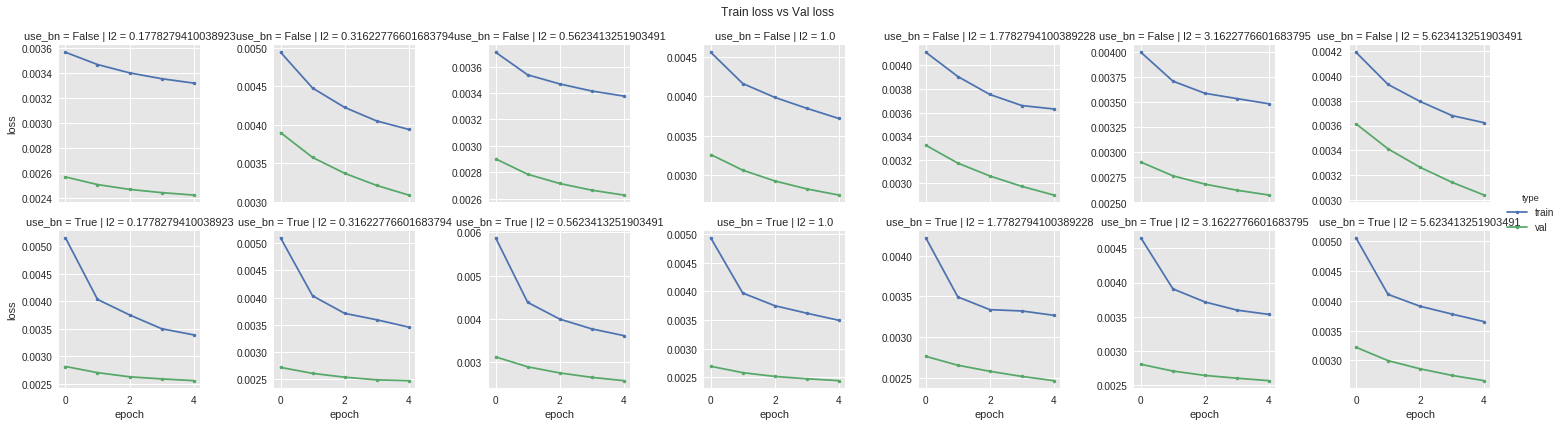

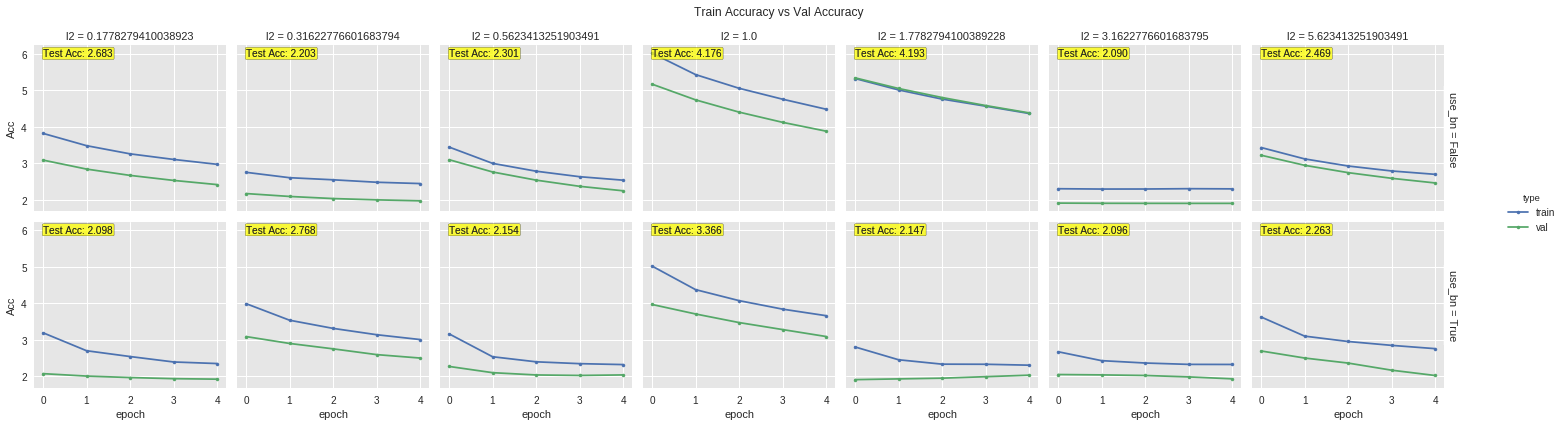

In [21]:
var1 = 'l2'
var2 = 'use_bn'

multiplier_list = [10 ** (-3 / 4), 10 ** (-1/2), 10 ** (- 1 / 4), 1, 10 ** (1 / 4), 10 ** (1 / 2), 10 ** (3 / 4)]
grid_hyperparameter_tuning(deepcopy(args), "exp3_l2_use_bn", "l2", [i * args.l2 for i in multiplier_list], 'use_bn', [True, False])

df = load_exp_result('exp3_l2_use_bn')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

var1_var2 = regularizer(df, var1, var2, mode = 'last')
setattr(args, var1, float(var1_var2[0]))
setattr(args, var2, bool(var1_var2[1]))

In [22]:
print(args.l2)

1.0


Namespace(batch_size=128, device='cuda', dropout=0.2, epoch=5, exp_name='exp4_optim_lr', hid_dim=512, input_dim=6, l2=1.0, lr=0.01, n_layers=3, optim='SGD', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 4.23/1.93, Loss(train/val) 0.03758/0.00238. Took 19.49 sec
Epoch 1, Acc(train/val): 2.29/1.90, Loss(train/val) 0.00317/0.00235. Took 19.32 sec
Epoch 2, Acc(train/val): 2.28/1.94, Loss(train/val) 0.00317/0.00243. Took 19.08 sec
Epoch 3, Acc(train/val): 2.30/1.91, Loss(train/val) 0.00319/0.00238. Took 19.33 sec
Epoch 4, Acc(train/val): 2.31/1.90, Loss(train/val) 0.00318/0.00242. Took 19.24 sec
Namespace(batch_size=128, device='cuda', dropout=0.2, epoch=5, exp_name='exp4_optim_lr', hid_dim=512, input_dim=6, l2=1.0, lr=0.001, n_layers=3, optim='SGD', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 2.43/1.91, Loss(train/val) 0.00354/0.00236. Took 19.44 sec
Epoch 1, Acc(train/val): 2.28/1.91, Loss(train/val) 0.00319/0.00235

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


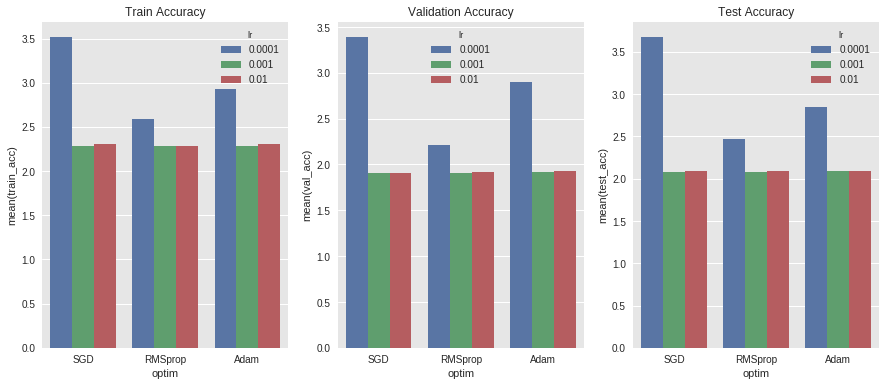

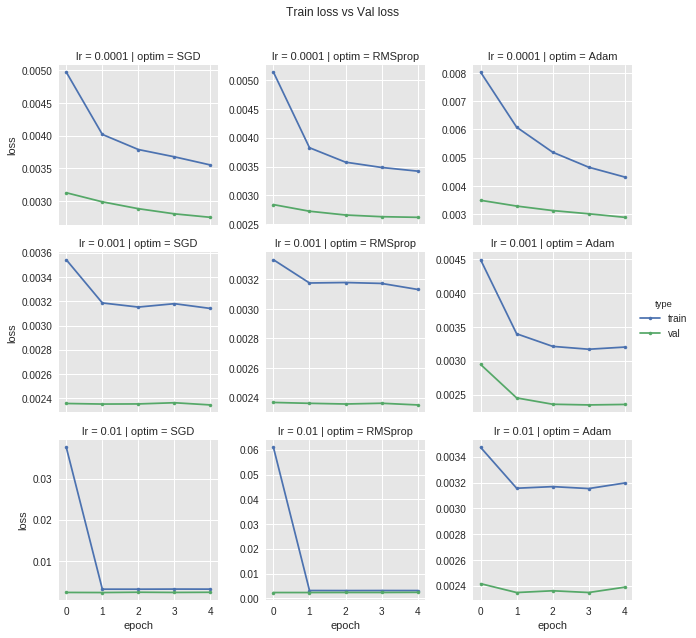

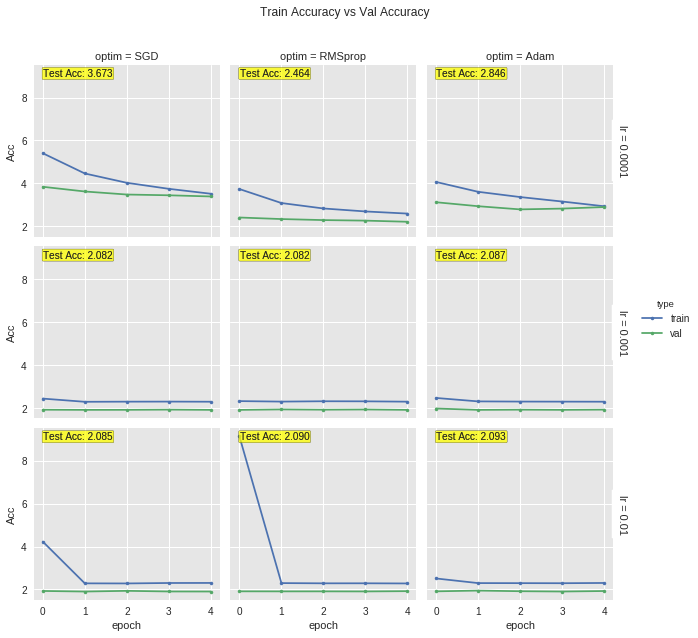

In [23]:
var1 = 'optim'
var2 = 'lr'

grid_hyperparameter_tuning(deepcopy(args), "exp4_optim_lr", var1, ['SGD', 'RMSprop', 'Adam'], var2, [.01, .001, .0001])

df = load_exp_result("exp4_optim_lr")

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

In [0]:
args.lr = .01
args.optim = "RMSprop"

model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
model.to(args.device)

loss_fn = nn.MSELoss()
if args.optim == 'SGD':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('In-valid optimizer choice')
    
# ===== List for epoch-wise data ====== #
train_losses = []
val_losses = []
train_accs = []
val_accs = []
# ===================================== #
for i in range(10):
    model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
    val_loss, val_acc = validate(model, partition, loss_fn, args)
        
    # ====== Add Epoch Data ====== #
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # ============================ #    

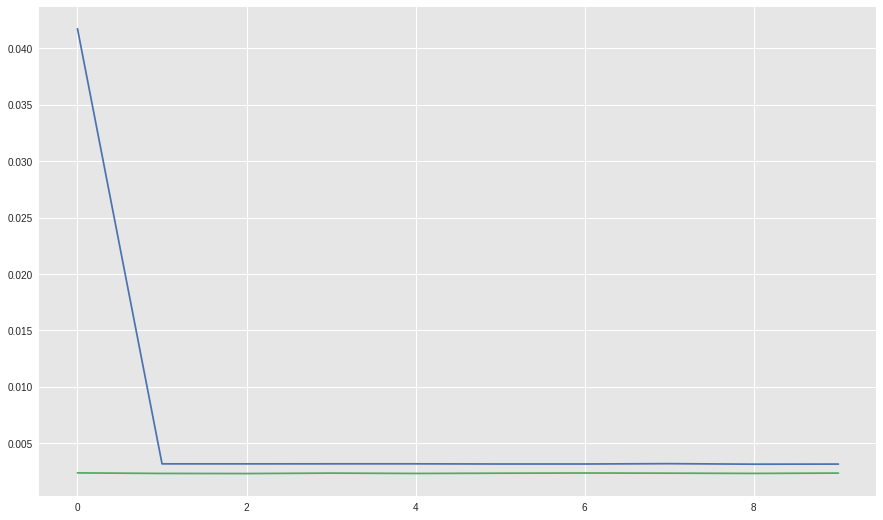

In [25]:
plt.plot([i for i in range(10)], train_losses)
plt.plot([i for i in range(10)], val_losses)
plt.show()

In [26]:
args.lr = args.lr / 10
if args.optim == 'SGD':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('In-valid optimizer choice')

for i in range(10):
    model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
    val_loss, val_acc = validate(model, partition, loss_fn, args)
    
    # ====== Add Epoch Data ====== #
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # ============================ #    
    print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}'.format(i + 10, train_acc, val_acc, train_loss, val_loss))

Epoch 10, Acc(train/val): 2.31/1.92, Loss(train/val) 0.00317/0.00235
Epoch 11, Acc(train/val): 2.29/1.92, Loss(train/val) 0.00315/0.00235
Epoch 12, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00318/0.00235
Epoch 13, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00318/0.00236
Epoch 14, Acc(train/val): 2.28/1.91, Loss(train/val) 0.00314/0.00237
Epoch 15, Acc(train/val): 2.30/1.92, Loss(train/val) 0.00318/0.00237
Epoch 16, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00315/0.00235
Epoch 17, Acc(train/val): 2.30/1.90, Loss(train/val) 0.00310/0.00234
Epoch 18, Acc(train/val): 2.30/1.92, Loss(train/val) 0.00316/0.00235
Epoch 19, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00313/0.00235


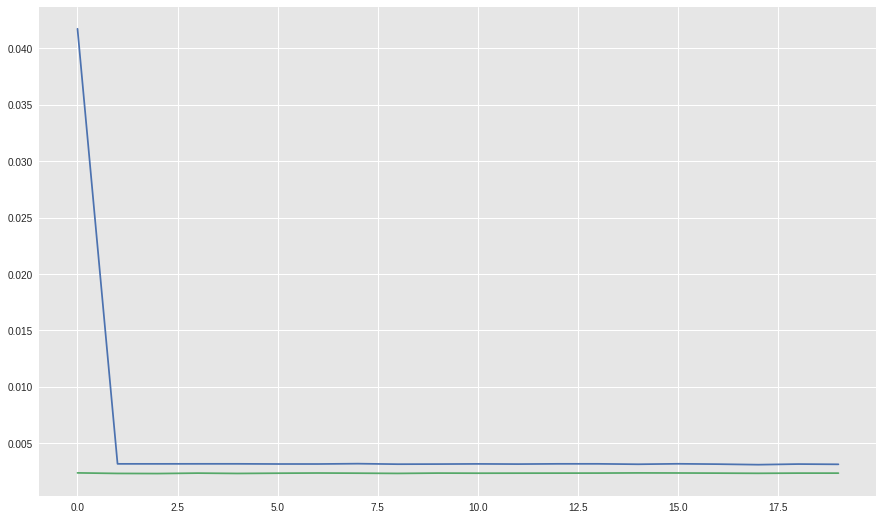

In [27]:
plt.plot([i for i in range(20)], train_losses)
plt.plot([i for i in range(20)], val_losses)
plt.show()

In [29]:
args.lr = args.lr / 10
if args.optim == 'SGD':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('In-valid optimizer choice')

for i in range(10):
    model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
    val_loss, val_acc = validate(model, partition, loss_fn, args)
    
    # ====== Add Epoch Data ====== #
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # ============================ #    
    print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}'.format(i + 20, train_acc, val_acc, train_loss, val_loss))

Epoch 20, Acc(train/val): 2.27/1.91, Loss(train/val) 0.00312/0.00235
Epoch 21, Acc(train/val): 2.30/1.91, Loss(train/val) 0.00320/0.00236
Epoch 22, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00317/0.00236
Epoch 23, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00314/0.00236
Epoch 24, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00317/0.00236
Epoch 25, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00320/0.00236
Epoch 26, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00316/0.00236
Epoch 27, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00318/0.00236
Epoch 28, Acc(train/val): 2.29/1.91, Loss(train/val) 0.00314/0.00236
Epoch 29, Acc(train/val): 2.30/1.91, Loss(train/val) 0.00319/0.00236


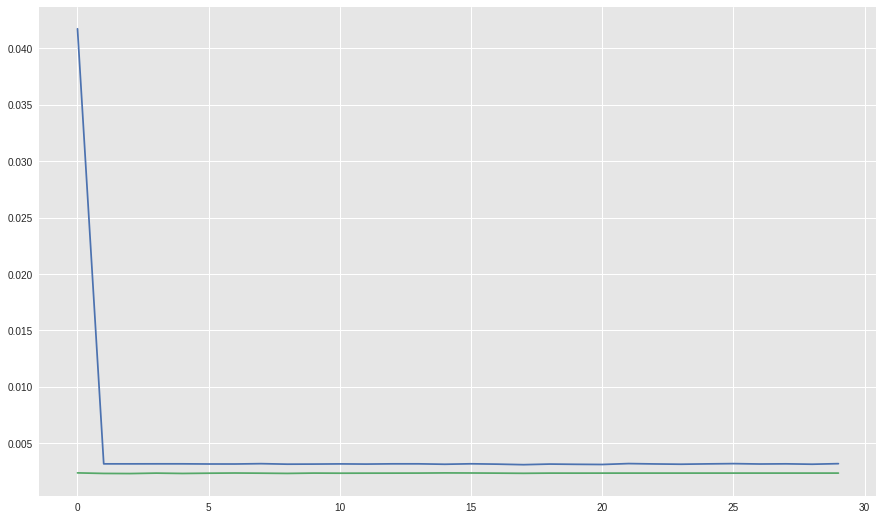

In [30]:
plt.plot([i for i in range(30)], train_losses)
plt.plot([i for i in range(30)], val_losses)
plt.show()

In [31]:
args.lr = args.lr / 10
if args.optim == 'SGD':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('In-valid optimizer choice')

for i in range(10):
    model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
    val_loss, val_acc = validate(model, partition, loss_fn, args)
    
    # ====== Add Epoch Data ====== #
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # ============================ #    
    print('Epoch {}, Acc(train/val): {:2.9f}/{:2.9f}, Loss(train/val) {:2.9f}/{:2.9f}'.format(i + 20, train_acc, val_acc, train_loss, val_loss))

Epoch 20, Acc(train/val): 2.285010654/1.911806788, Loss(train/val) 0.003161765/0.002356409
Epoch 21, Acc(train/val): 2.290386739/1.911846484, Loss(train/val) 0.003191394/0.002356432
Epoch 22, Acc(train/val): 2.291782602/1.911852019, Loss(train/val) 0.003152596/0.002356445
Epoch 23, Acc(train/val): 2.293799706/1.911853756, Loss(train/val) 0.003167655/0.002356431
Epoch 24, Acc(train/val): 2.286669892/1.911846484, Loss(train/val) 0.003158911/0.002356440
Epoch 25, Acc(train/val): 2.297831224/1.911841341, Loss(train/val) 0.003190396/0.002356433
Epoch 26, Acc(train/val): 2.295266576/1.911830306, Loss(train/val) 0.003173588/0.002356419
Epoch 27, Acc(train/val): 2.298814597/1.911830306, Loss(train/val) 0.003176553/0.002356412
Epoch 28, Acc(train/val): 2.289991042/1.911824788, Loss(train/val) 0.003188513/0.002356411
Epoch 29, Acc(train/val): 2.283150932/1.911797898, Loss(train/val) 0.003153049/0.002356407


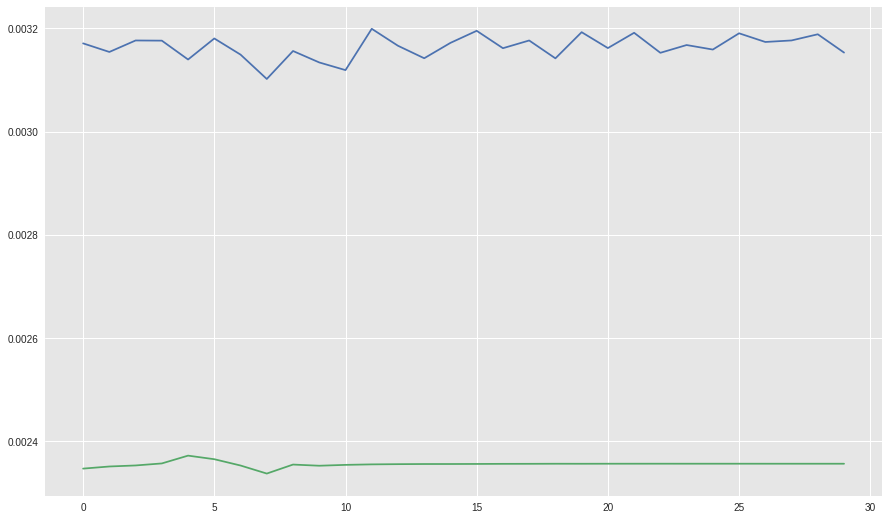

In [32]:
plt.plot([i for i in range(30)], train_losses[10:])
plt.plot([i for i in range(30)], val_losses[10:])
plt.show()

In [33]:
args.lr = args.lr / 10
if args.optim == 'SGD':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
elif args.optim == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('In-valid optimizer choice')

for i in range(10):
    model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
    val_loss, val_acc = validate(model, partition, loss_fn, args)
    
    # ====== Add Epoch Data ====== #
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    # ============================ #    
    print('Epoch {}, Acc(train/val): {:2.9f}/{:2.9f}, Loss(train/val) {:2.9f}/{:2.9f}'.format(i + 40, train_acc, val_acc, train_loss, val_loss))

Epoch 40, Acc(train/val): 2.299219152/1.911810330, Loss(train/val) 0.003173596/0.002356417
Epoch 41, Acc(train/val): 2.292046236/1.911815814, Loss(train/val) 0.003178034/0.002356417
Epoch 42, Acc(train/val): 2.288171390/1.911814025, Loss(train/val) 0.003122942/0.002356418
Epoch 43, Acc(train/val): 2.301401211/1.911815814, Loss(train/val) 0.003193065/0.002356419
Epoch 44, Acc(train/val): 2.296952870/1.911815814, Loss(train/val) 0.003139467/0.002356418
Epoch 45, Acc(train/val): 2.291598455/1.911815814, Loss(train/val) 0.003159659/0.002356419
Epoch 46, Acc(train/val): 2.279608566/1.911821331, Loss(train/val) 0.003146843/0.002356422
Epoch 47, Acc(train/val): 2.299044915/1.911821331, Loss(train/val) 0.003191104/0.002356422
Epoch 48, Acc(train/val): 2.301207646/1.911823051, Loss(train/val) 0.003189225/0.002356424
Epoch 49, Acc(train/val): 2.288461550/1.911824788, Loss(train/val) 0.003189261/0.002356426


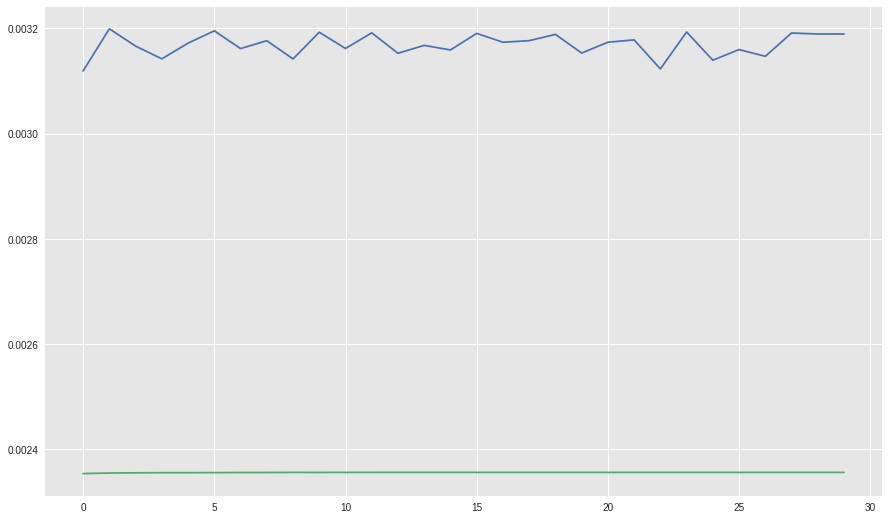

In [34]:
plt.plot([i for i in range(30)], train_losses[20:])
plt.plot([i for i in range(30)], val_losses[20:])
plt.show()